#Fashion MNIST 
- **Fashion MNIST dataset**: Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.
- **Goal**: classify grayscale Fashion-MNIST images into 10 classes
- **[Keras MNIST](https://keras.io/examples/vision/mnist_convnet/)**

In [1]:
# https://www.tensorflow.org/guide/keras/overview
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(f"Tensorflow: {tf.__version__}\nKeras: {keras.__version__}")

Tensorflow: 2.11.0
Keras: 2.11.0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [3]:
np.random.seed(2023)

In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_nums = len(class_names)
print(class_nums)
input_shape = (28,28,1)

10


# 1. Load Data

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
print(type(X_train), X_train.dtype)

<class 'numpy.ndarray'> uint8


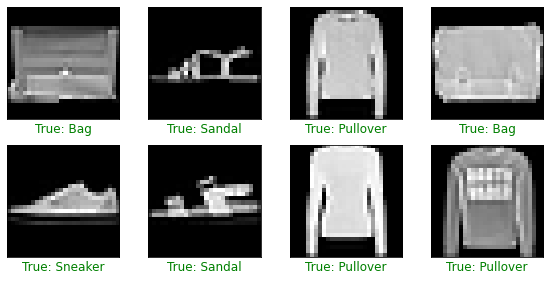

In [7]:
from typing import Optional
def plot_data(x_data: np.ndarray, y_data: np.ndarray, y_proba: Optional[np.ndarray]=None) -> None:
  nrows, ncols = 2, 4
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,4))
  len_x = x_data.shape[0]
  for idx in range(nrows*ncols):
    ax = axes[idx // ncols, idx % ncols]
    img_idx = random.randint(0, len_x)
    
    ax.imshow(x_data[img_idx], cmap='gray')
    
    ax.set(xticks=[], yticks=[])
    color = 'green'
    true_label_str = f"True: {class_names[y_data[img_idx]]}"
    if y_proba is not None: 
      predicted_idx = np.argmax(y_proba[img_idx])
      predicted_label = class_names[predicted_idx]
      color = 'red' if predicted_idx != y_data[img_idx] else color
      predicted_label_str = f"\nPredicted: {predicted_label}"
    
    img_title = true_label_str if y_proba is None else true_label_str + predicted_label_str
    
    ax.set_xlabel(img_title, color=color, fontsize=12)
  
  plt.tight_layout()
  plt.show()

plot_data(X_train, y_train)

# 2. Image Pre-processing
- Reshaping it into the shape the model expects and scaling it so that all values are in the `[0, 1]` interval
- Transform from `unit8` it into a `float32`

In [8]:
# Convert to float32 & Scale images to the [0, 1] range for training
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Make sure images have shape (60000, 28, 28) => (60000, 28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [9]:
# convert class vectors to binary class matrices: 1 => [0 1 0 0 ...] 
# 1              => sparse_categorical_crossentropy
# [0 1 0 0 ...]  => categorical_crossentropy
y_train_label = keras.utils.to_categorical(y_train, class_nums)
y_test_label = keras.utils.to_categorical(y_test, class_nums)

# 3. Network Architecture
- For  **binary classification** or multilabel binary classification, then we would use the `"sigmoid"` (i.e., logistic) activation function in the output layer instead of the `"softmax"` activation function, and we would use the `"binary_crossentropy"` loss.
- Loss function:
  - `"sparse_categorical_crossentropy"` loss because we have sparse labels: (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. 
  - `"categorical_crossentropy"`: If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. 

In [10]:
model = keras.models.Sequential([
    layers.Flatten(input_shape=input_shape), #to convert each input image into a 1D array
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(class_nums, activation="softmax")
])

# model = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), # ConVo needs (28,28,1)
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(class_nums, activation="softmax"),
#     ]
# )

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [12]:
"""
## Train the model
"""

epochs = 10
batch_size = 128
history = model.fit(X_train, 
                    y_train_label, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    )

Epoch 1/10
422/422 [==============================] - 16s 36ms/step - loss: 0.5609 - accuracy: 0.7956 - val_loss: 0.4343 - val_accuracy: 0.8333
Epoch 2/10
422/422 [==============================] - 11s 27ms/step - loss: 0.3816 - accuracy: 0.8589 - val_loss: 0.3735 - val_accuracy: 0.8620
Epoch 3/10
422/422 [==============================] - 6s 15ms/step - loss: 0.3359 - accuracy: 0.8752 - val_loss: 0.3677 - val_accuracy: 0.8697
Epoch 4/10
422/422 [==============================] - 7s 17ms/step - loss: 0.3101 - accuracy: 0.8841 - val_loss: 0.3394 - val_accuracy: 0.8787
Epoch 5/10
422/422 [==============================] - 6s 15ms/step - loss: 0.2896 - accuracy: 0.8912 - val_loss: 0.3178 - val_accuracy: 0.8830
Epoch 6/10
422/422 [==============================] - 7s 18ms/step - loss: 0.2725 - accuracy: 0.8968 - val_loss: 0.3877 - val_accuracy: 0.8507
Epoch 7/10
422/422 [==============================] - 6s 15ms/step - loss: 0.2586 - accuracy: 0.9028 - val_loss: 0.3431 - val_accuracy: 0.88

In [21]:
history_dict = history.history

In [38]:
train_loss, val_loss = history_dict['loss'], history_dict['val_loss']
train_acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']

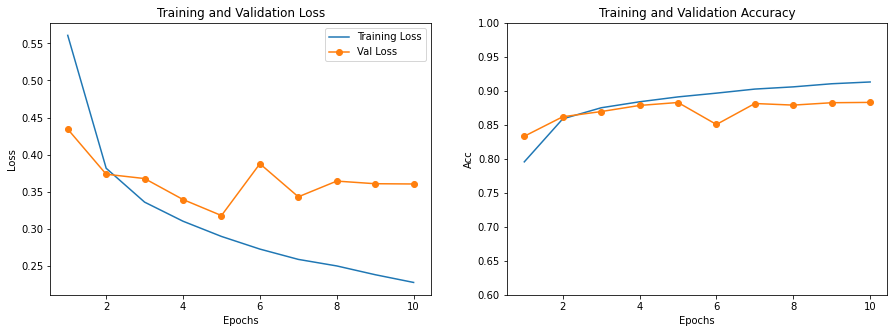

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
epoch_runs = [i+1 for i in range(epochs)]
ax1.plot(epoch_runs, train_loss, label="Training Loss")
ax1.plot(epoch_runs, val_loss, marker='o', label="Val Loss")
ax1.set(title='Training and Validation Loss', xlabel='Epochs', ylabel='Loss')
ax1.legend()

ax2.plot(epoch_runs, train_acc, label="Training Acc")
ax2.plot(epoch_runs, val_acc, marker='o', label="Val Acc")
ax2.set(title='Training and Validation Accuracy', xlabel='Epochs', ylabel='Acc', ylim=[0.6, 1])
#  plt.gca().set_ylim(0,1) #set vertical range to [0-1]
plt.show()

# 4. Model Evaluation

In [15]:
"""
## Evaluate the trained model
"""

score = model.evaluate(X_test, y_test_label, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.37464776635169983
Test accuracy: 0.8831999897956848


# 5. Prediction

In [16]:
X_sample = X_test[:3]
y_proba = model.predict(X_sample)
pd.DataFrame([[*y_p, class_names[y_l]] for y_p, y_l in zip(y_proba.round(3), y_test[:3])], 
              columns=[*class_names, 'Label'])


1/1 [==============================] - 0s 104ms/step


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.999,Ankle boot
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,Pullover
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,Trouser


In [17]:
predictions = np.argmax(y_proba, axis=1)
print([class_names[pred_idx] for pred_idx in predictions])

['Ankle boot', 'Pullover', 'Trouser']


In [18]:
y_proba = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


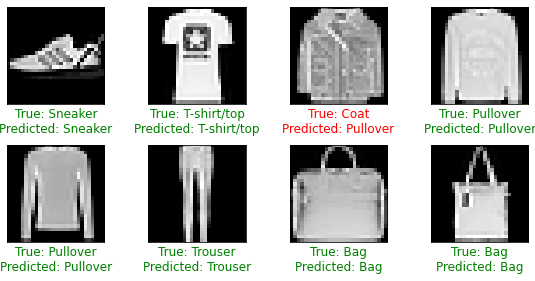

In [44]:
plot_data(X_test, y_test, y_proba)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, np.argmax(y_proba, axis=1), target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.79      0.83      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.80      0.79      0.80      1000
       Dress       0.78      0.94      0.85      1000
        Coat       0.78      0.83      0.81      1000
      Sandal       0.99      0.95      0.97      1000
       Shirt       0.78      0.64      0.70      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.95      0.98      0.96      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

